In [22]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf

from sklearn.metrics import mean_squared_error 
np.random.seed(42)
warnings.filterwarnings('ignore')

# 3 Going On A Random Walk 

### 3.1 Simulating the Random Walk Process

In [3]:
white_noise = np.random.standard_normal(1000)       
initial = 0
random_walk = np.append([initial], initial + np.cumsum(white_noise)) 

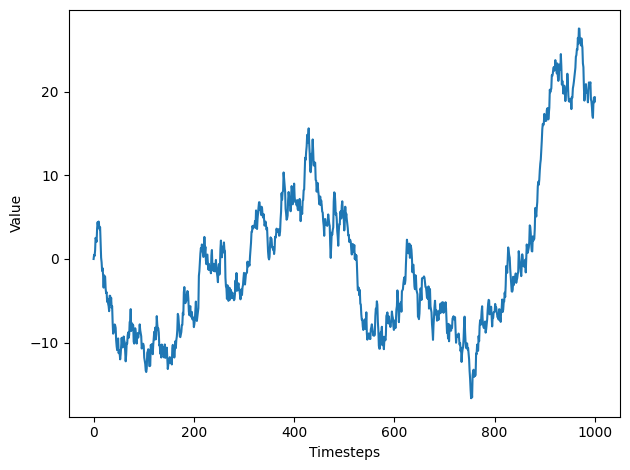

In [4]:
fig, ax = plt.subplots()
 
ax.plot(random_walk)
ax.set_xlabel('Timesteps')
ax.set_ylabel('Value')
 
plt.tight_layout()

### 3.2 Defining the Random Walk

A random walk is a series whose first difference is stationary and uncorrelated.

#### Stationarity 
Use differencing to create a stationary time series.  
Use the Augmented Dicker-Fuller test to examine stationarity.  
Null hypothesis: a unit root is present => the time series is not stationary.  
More negative ADF statistic & smaller p-value => stronger rejection of the null hypothesis  

#### The Auto Correlation Function
The autocorrelation function (ACF) measures the linear relationship between lagged values of a time series.

#### Is random walk a stationary process?

In [9]:
# p-value > 0.05, cannot reject the null hypothesis that it's not stationary.
adf_statistic, p_value, *_ = adfuller(random_walk)
print(f'ADF Statistic: {adf_statistic}')
print(f'p-value: {p_value}')

ADF Statistic: -0.965723146907462
p-value: 0.7655598622839761


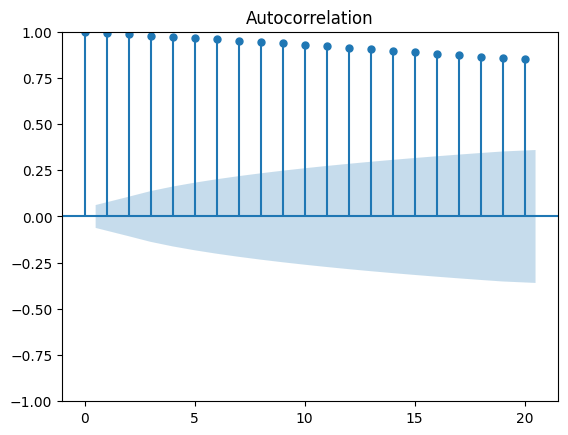

In [ ]:
# the shaded area is the confidence interval. 
# a point in the shaded area is not significantly different from zero
fig = plot_acf(random_walk, lags=20)

In [13]:
# reject the null hypothesis that there's a unit root
diff_random_walk = np.diff(random_walk, n=1)
adf_statistic, p_value, *_ = adfuller(diff_random_walk)
print(f'ADF Statistic: {adf_statistic}')
print(f'p-value: {p_value}')

ADF Statistic: -31.811093841491463
p-value: 0.0


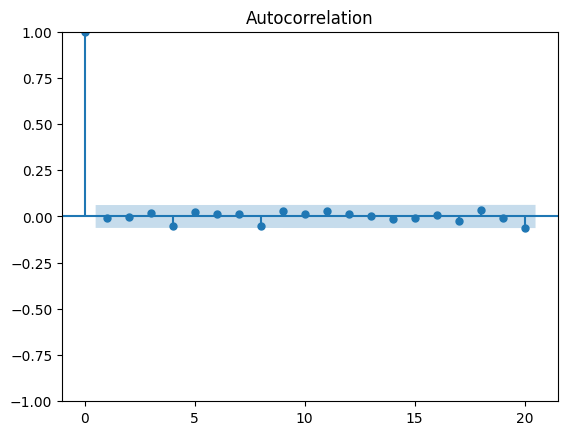

In [14]:
fig = plot_acf(diff_random_walk, lags=20)

Is GOOGL a random walk?

In [23]:
df = pd.read_csv('./data/GOOGL.csv')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2020-04-27,1292.000000,1294.099976,1265.060059,1270.859985,1270.859985,2209300
1,2020-04-28,1283.199951,1284.760010,1230.380005,1232.589966,1232.589966,4035000
2,2020-04-29,1345.000000,1360.150024,1326.729980,1342.180054,1342.180054,5417900
3,2020-04-30,1331.359985,1350.000000,1321.500000,1346.699951,1346.699951,2792100
4,2020-05-01,1324.089966,1351.430054,1309.660034,1317.319946,1317.319946,2443600


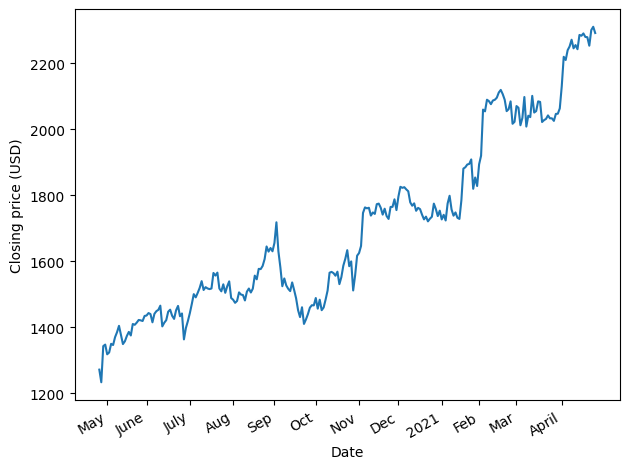

In [24]:
fig, ax = plt.subplots()
 
ax.plot(df['Date'], df['Close'])
ax.set_xlabel('Date')
ax.set_ylabel('Closing price (USD)')
 
plt.xticks(
    [4, 24, 46, 68, 89, 110, 132, 152, 174, 193, 212, 235], 
    ['May', 'June', 'July', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', 2021, 'Feb', 'Mar', 'April']        
)
fig.autofmt_xdate()
plt.tight_layout()

In [ ]:
# the closing price is not stationary
google_adf_result = adfuller(df['Close'])

print(f'ADF Statistic: {google_adf_result[0]}')
print(f'p-value: {google_adf_result[1]}')

ADF Statistic: 0.1602504866477152
p-value: 0.9699419435913058


In [ ]:
# the first difference is stationary
diff_close = np.diff(df['Close'], n=1)
diff_google_adf_result = adfuller(diff_close)

print(f'ADF Statistic: {diff_google_adf_result[0]}')
print(f'p-value: {diff_google_adf_result[1]}')

ADF Statistic: -5.30343970429522
p-value: 5.386530961454919e-06


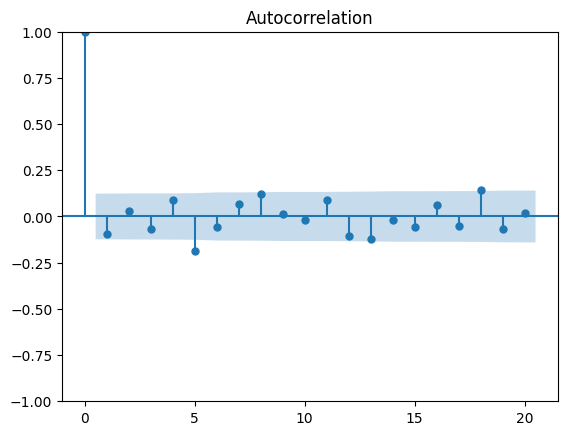

In [ ]:
# the first difference is also not auto-correlated
fig = plot_acf(diff_close, lags=20)

GOOGL can be approximated by a random walk.

### 3.3 Forecasting a random walk
#### 3.3.1 Forcasting on a long horizon
The conculsion: It just doesn't make sense to predict a long horizon of a random walk.

In [25]:
df = pd.DataFrame({'value': random_walk})
 
train = df[:800]
test = df[800:]

We can predict the future using historical mean.

In [26]:
mean = np.mean(train.value)
test.loc[:, 'pred_mean'] = mean
test.head()

,value,pred_mean
800,-6.318233,-3.172594
801,-5.379950,-3.172594
802,-5.895994,-3.172594
803,-5.799873,-3.172594
804,-6.262149,-3.172594


We can predict the future using the last value.

In [27]:
last_value = train.iloc[-1].value
test.loc[:, 'pred_last'] = last_value
test.head()

,value,pred_mean,pred_last
800,-6.318233,-3.172594,-6.347989
801,-5.379950,-3.172594,-6.347989
802,-5.895994,-3.172594,-6.347989
803,-5.799873,-3.172594,-6.347989
804,-6.262149,-3.172594,-6.347989


We can also predict the future by extrapolating the slope.

In [30]:
deltaX = 800 - 1            
deltaY = last_value - 0    
drift = deltaY / deltaX
 
x_vals = np.arange(800, 1001, 1)
pred_drift = drift * x_vals
test.loc[:, 'pred_drift'] = pred_drift

test.head()

,value,pred_mean,pred_last,pred_drift
800,-6.318233,-3.172594,-6.347989,-6.355934
801,-5.379950,-3.172594,-6.347989,-6.363879
802,-5.895994,-3.172594,-6.347989,-6.371824
803,-5.799873,-3.172594,-6.347989,-6.379769
804,-6.262149,-3.172594,-6.347989,-6.387714


We can visualize these three methods. As shown on the chart, all of them are faulty.

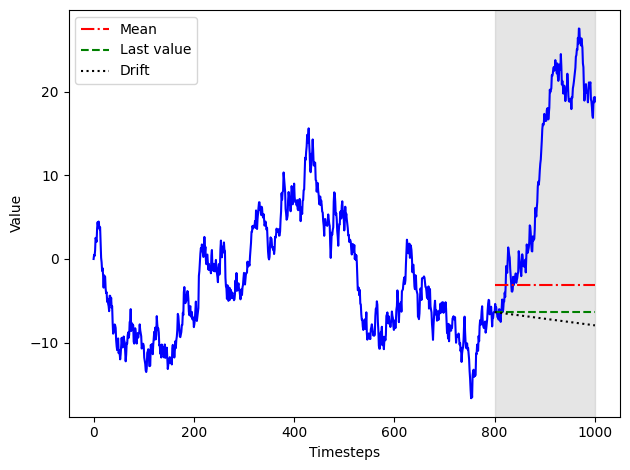

In [31]:
fig, ax = plt.subplots()
 
ax.plot(train.value, 'b-')                                
ax.plot(test['value'], 'b-')                              
ax.plot(test['pred_mean'], 'r-.', label='Mean')           
ax.plot(test['pred_last'], 'g--', label='Last value')     
ax.plot(test['pred_drift'], 'k:', label='Drift')          

ax.axvspan(800, 1000, color='#808080', alpha=0.2)         
ax.legend(loc=2)                                          
 
ax.set_xlabel('Timesteps')
ax.set_ylabel('Value')

plt.tight_layout()

We can see that the best prediction is to use the historical mean, but the MSE is over 300 and still very high.

In [32]:
for pred_column in ['pred_mean', 'pred_last', 'pred_drift']:
    print(f'{pred_column} mean square error: ', mean_squared_error(test['value'], test[pred_column]))

pred_mean mean square error:  324.70521176394925
pred_last mean square error:  424.0821648107212
pred_drift mean square error:  462.1090174239379


#### 3.3.2 Forecasting the next timestep
Simply used the initial observed value to predict the next timestep. The result seems to be good.

0.9256876651440581


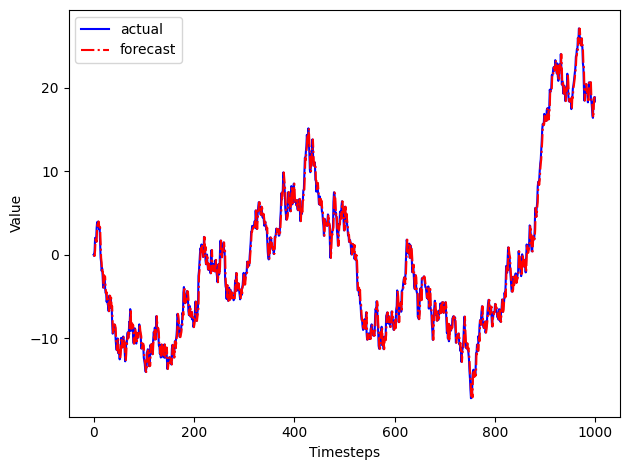

In [20]:
df_shift = df.shift(periods=1)

fig, ax = plt.subplots()
ax.plot(df, 'b-', label='actual')
ax.plot(df_shift, 'r-.', label='forecast')
ax.legend(loc=2)
ax.set_xlabel('Timesteps')
ax.set_ylabel('Value')
plt.tight_layout()

mse_one_step = mean_squared_error(test['value'], df_shift[800:])
print(mse_one_step)